# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 20/05/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [2]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.model_build import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.callbacks import *

# from src.model.diffusion_funcionality import *

In [4]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-21 22:12:45.461358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 22:12:45.465449: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 22:12:45.465559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Dataset

- The shape of the dataset is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


2024-05-20 19:35:08.876753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


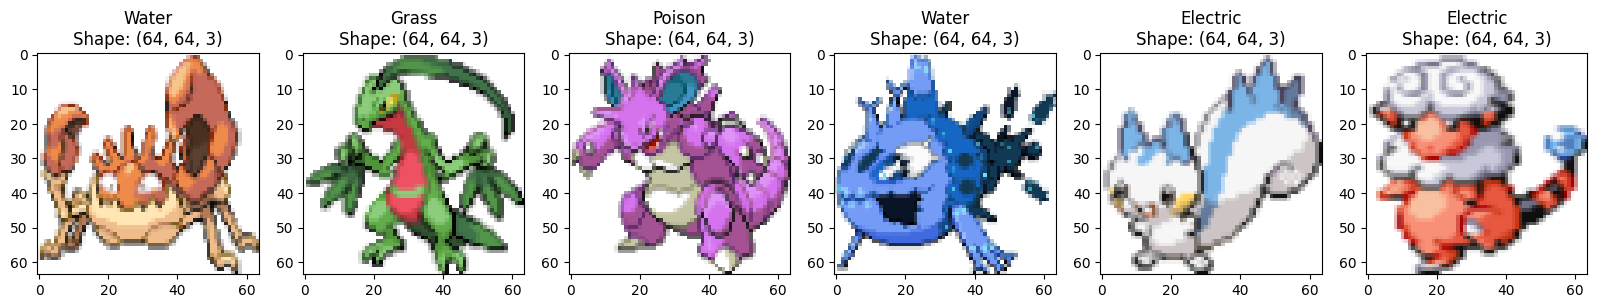

2024-05-20 19:35:09.737276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

In [7]:
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/100


I0000 00:00:1716233748.010219   51266 service.cc:145] XLA service 0x748d50002050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716233748.010242   51266 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-20 19:35:48.400779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1716233748.912488   51266 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-05-20 19:35:49.774339: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1716233751.158550   51792 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11', 8 bytes

13/63 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - loss: 1.2409

In [ ]:
model.plot_samples(6)

## 2.2. Save Model

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [9]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "./diffusion_models/models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.h5"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [10]:
# Save the model
# model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{scheduler}_ddpm"

# save_model(model, model_name)

# Save the model # TODO: FIX THIS

[BACK TO TOP](#top)